In [9]:
pip install gradio transformers bitsandbytes accelerate torch gradio shap pydotplus graphviz seaborn graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


Model saved as multi_output_gym_recommendation_model.pkl
Classification report for Fitness Type:
                  precision    recall  f1-score   support

  Cardio Fitness       1.00      1.00      1.00      1507
Muscular Fitness       1.00      1.00      1.00      1404

        accuracy                           1.00      2911
       macro avg       1.00      1.00      1.00      2911
    weighted avg       1.00      1.00      1.00      2911



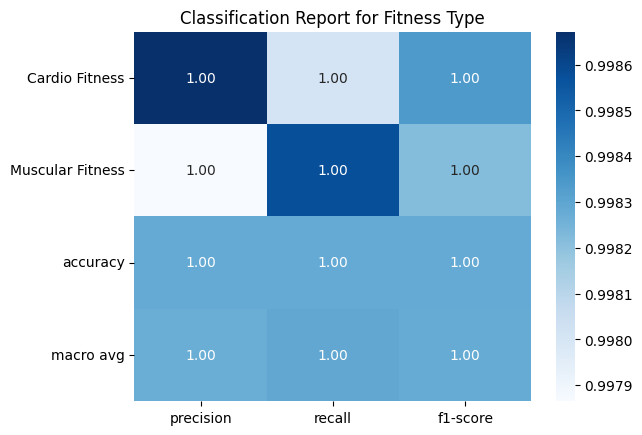



Classification report for Exercises:
                                                              precision    recall  f1-score   support

     Brisk walking, cycling, swimming, running , or dancing.       1.00      0.99      1.00       829
      Squats, deadlifts, bench presses, and overhead presses       0.99      1.00      1.00       722
Squats, yoga, deadlifts, bench presses, and overhead presses       0.99      1.00      1.00       681
                                    Walking, Yoga, Swimming.       1.00      0.99      1.00       361
               brisk walking, cycling, swimming, or dancing.       1.00      0.99      1.00       318

                                                    accuracy                           1.00      2911
                                                   macro avg       1.00      0.99      1.00      2911
                                                weighted avg       1.00      1.00      1.00      2911



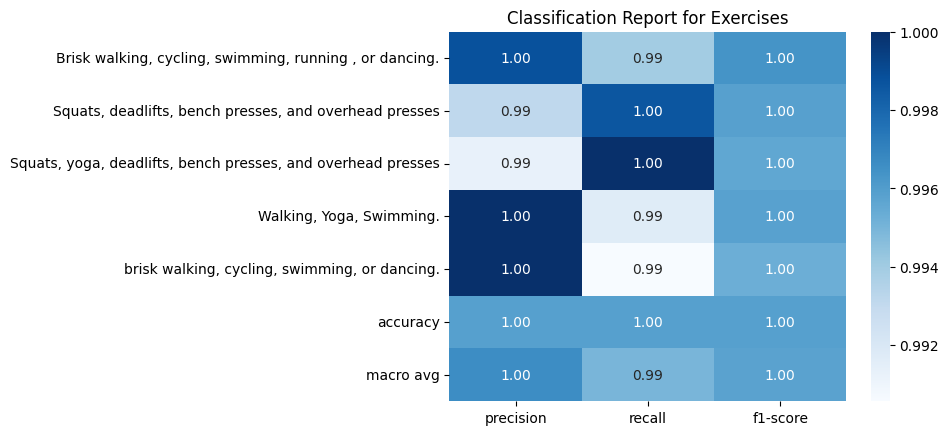



Classification report for Equipment:
                                                                                      precision    recall  f1-score   support

                                                              Dumbbells and barbells       0.92      0.98      0.95       363
                                       Dumbbells, barbells and Blood glucose monitor       0.97      0.94      0.95       363
                               Ellipticals, Indoor Rowers,Treadmills, Rowing machine       0.93      0.94      0.94       665
                           Ellipticals, Indoor Rowers,Treadmills, and Rowing machine       0.92      0.86      0.89       160
                                                     Kettlebell, Dumbbells, Yoga Mat       0.95      0.95      0.95       356
                                          Kettlebell, Dumbbells, Yoga Mat, Treadmill       0.96      0.97      0.96       314
                        Light athletic shoes, resistance bands, and light dumb

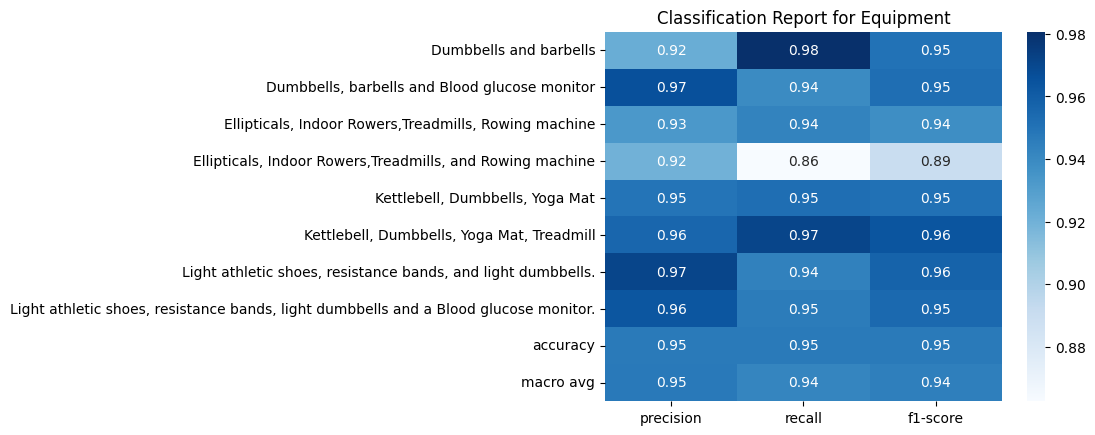

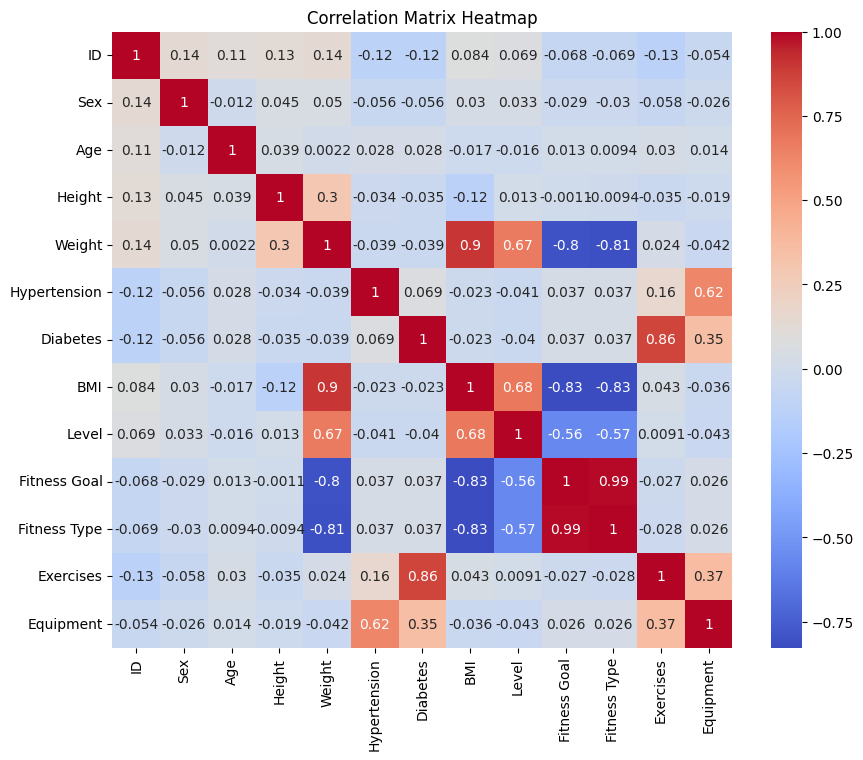

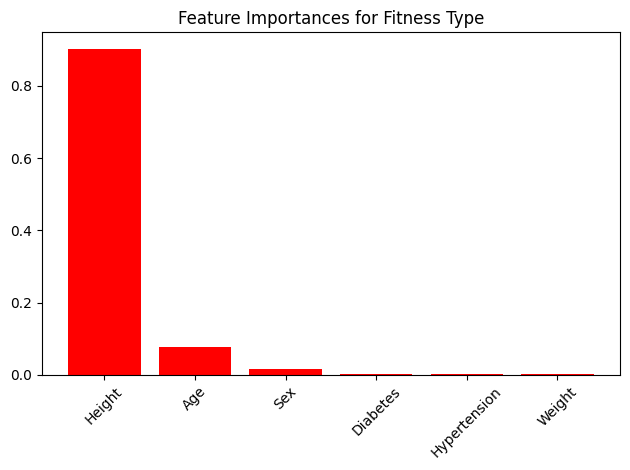

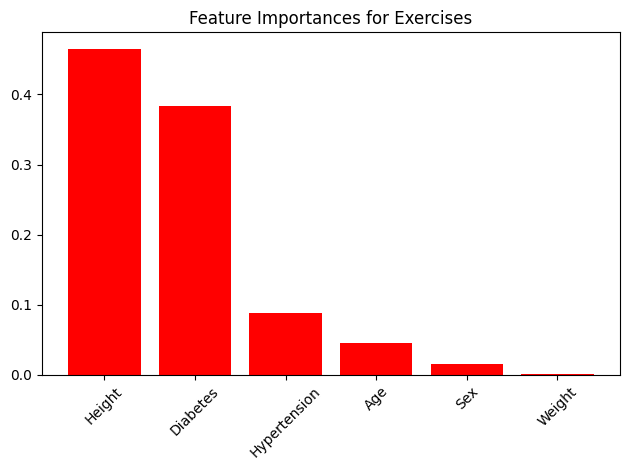

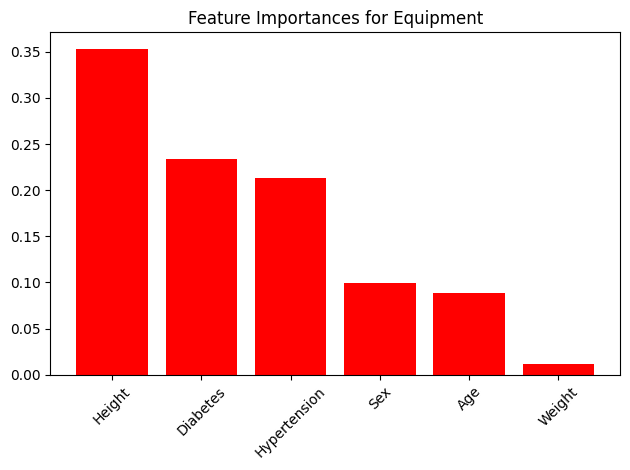

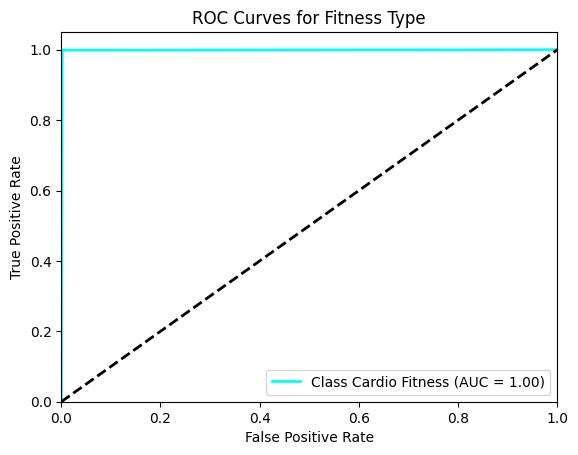

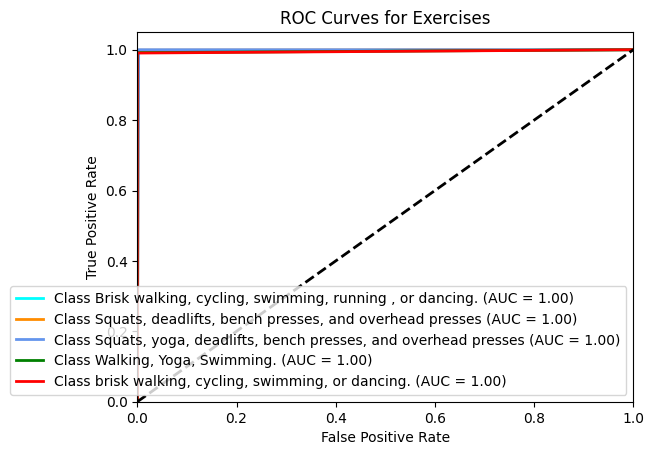

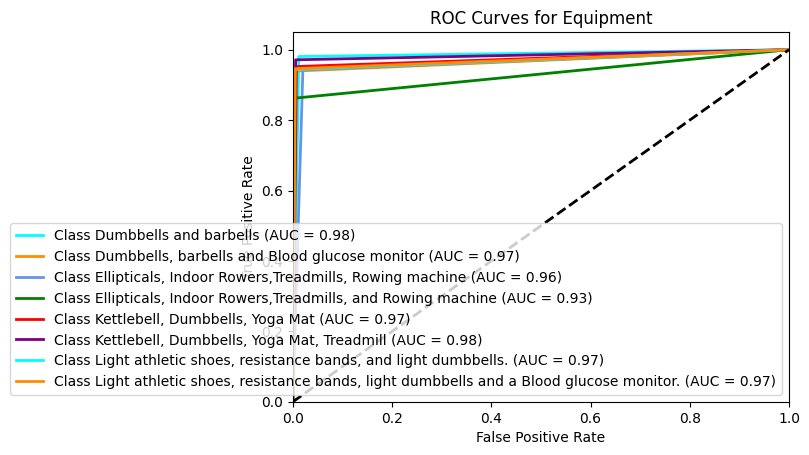

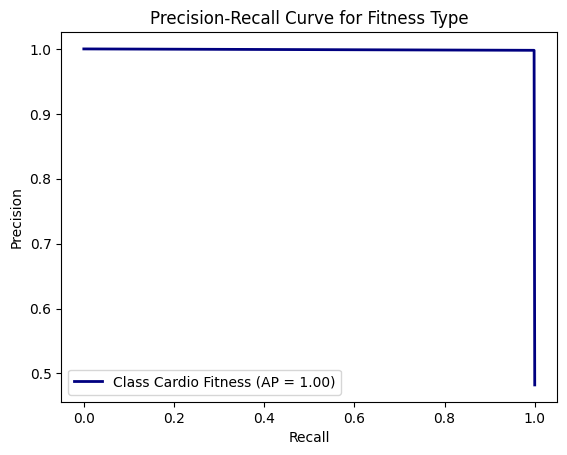

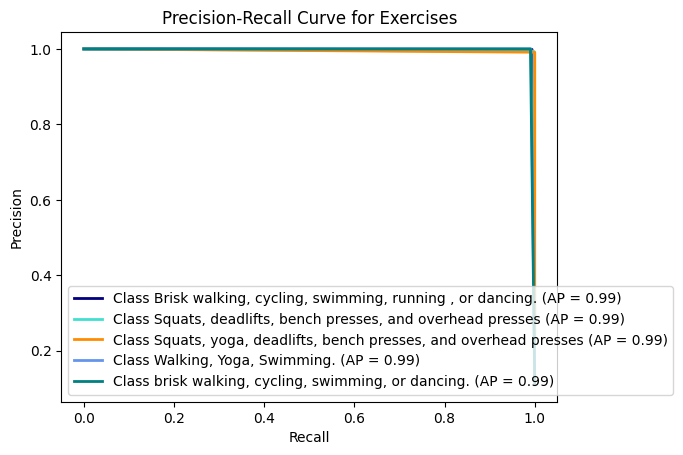

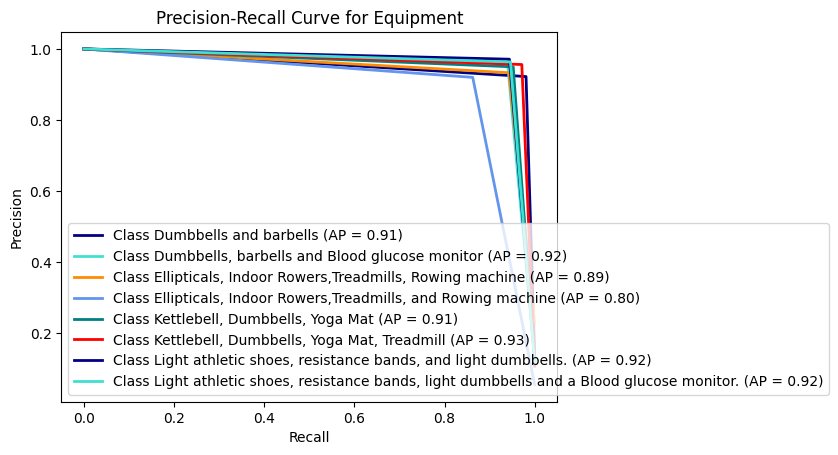

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.tree import export_graphviz
import pydotplus

# Load data
dataset_path = '/content/gym recommendation.xlsx'  # Update the path to your dataset
data = pd.read_excel(dataset_path, sheet_name='Sheet1')

# Data preprocessing
data['Sex'] = data['Sex'].map({'Male': 1, 'Female': 0})
data['Hypertension'] = data['Hypertension'].map({'Yes': 1, 'No': 0})
data['Diabetes'] = data['Diabetes'].map({'Yes': 1, 'No': 0})

data['BMI'] = data['Weight'] / (data['Height'] ** 2)
data['Level'] = data['BMI'].apply(lambda x: 1 if x >= 18.5 else 0)
data['Fitness Goal'] = data['BMI'].apply(lambda x: 0 if x >= 25 else 1)

# Filter out the "Equipment Required" category from the target variable
data = data[data['Equipment'] != 'Equipment Required']

# Encode categorical variables
label_encoders = {}
for column in ['Fitness Type', 'Exercises', 'Equipment']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target
X = data[['Sex', 'Age', 'Height', 'Weight', 'Hypertension', 'Diabetes']]
y = data[['Fitness Type', 'Exercises', 'Equipment']]

# Handle missing values in X and y
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.mode().iloc[0])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numerical_features = ['Age', 'Height', 'Weight']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# Multi-output Random Forest model
multi_output_model = MultiOutputClassifier(RandomForestClassifier(random_state=42, n_estimators=100))

# Create the final pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', multi_output_model)
])

# Train the model
model.fit(X_train, y_train)

# Save the model
model_filename = 'multi_output_gym_recommendation_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

# Predict and evaluate each output separately
y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['Fitness Type', 'Exercises', 'Equipment'])

# Decode predictions back to original labels for better interpretation
for column in ['Fitness Type', 'Exercises', 'Equipment']:
    y_test[column] = label_encoders[column].inverse_transform(y_test[column])
    y_pred_df[column] = label_encoders[column].inverse_transform(y_pred_df[column])

# Save label encoders
for column, le in label_encoders.items():
    joblib.dump(le, f'{column}_label_encoder.pkl')

# Function to plot classification report as heatmap
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df = df.iloc[:-1, :]  # Exclude 'accuracy' row
    sns.heatmap(df.iloc[:, :-1], annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.show()

# Plot classification report heatmaps
for column in ['Fitness Type', 'Exercises', 'Equipment']:
    print(f"Classification report for {column}:")
    print(classification_report(y_test[column], y_pred_df[column]))
    plot_classification_report(y_test[column], y_pred_df[column], f'Classification Report for {column}')
    print("\n")

# Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))

# Exclude non-numeric columns
numeric_cols = data.select_dtypes(include=['number'])
corr = numeric_cols.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Feature Importance Plots for Each Output
feature_names = X.columns
for i, target in enumerate(['Fitness Type', 'Exercises', 'Equipment']):
    importances = model.named_steps['classifier'].estimators_[i].feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title(f'Feature Importances for {target}')
    plt.bar(range(X.shape[1]), importances[indices], color='r', align='center')
    plt.xticks(range(X.shape[1]), [feature_names[j] for j in indices], rotation=45)
    plt.tight_layout()
    plt.show()

# ROC Curves for Multi-Class Classification
for i, target in enumerate(['Fitness Type', 'Exercises', 'Equipment']):
    # Binarize the output labels
    classes = np.unique(y_test[target])
    y_test_bin = label_binarize(y_test[target], classes=classes)
    y_pred_bin = label_binarize(y_pred_df[target], classes=classes)
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_pred_bin[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for j, color in zip(range(n_classes), colors):
        plt.plot(fpr[j], tpr[j], color=color, lw=2,
                 label='Class {0} (AUC = {1:0.2f})'.format(classes[j], roc_auc[j]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {target}')
    plt.legend(loc="lower right")
    plt.show()

# Precision-Recall Curves
for i, target in enumerate(['Fitness Type', 'Exercises', 'Equipment']):
    # Binarize the output labels
    classes = np.unique(y_test[target])
    y_test_bin = label_binarize(y_test[target], classes=classes)
    y_pred_bin = label_binarize(y_pred_df[target], classes=classes)
    n_classes = y_test_bin.shape[1]

    precision = dict()
    recall = dict()
    average_precision = dict()

    for j in range(n_classes):
        precision[j], recall[j], _ = precision_recall_curve(y_test_bin[:, j], y_pred_bin[:, j])
        average_precision[j] = average_precision_score(y_test_bin[:, j], y_pred_bin[:, j])

    # Plot Precision-Recall curve
    plt.figure()
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red'])
    for j, color in zip(range(n_classes), colors):
        plt.plot(recall[j], precision[j], color=color, lw=2,
                 label='Class {0} (AP = {1:0.2f})'.format(classes[j], average_precision[j]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {target}')
    plt.legend(loc="lower left")
    plt.show()





Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 716ms/step - accuracy: 0.5080 - loss: 0.6916 - val_accuracy: 0.6293 - val_loss: 0.6801
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6183 - loss: 0.6721 - val_accuracy: 0.7415 - val_loss: 0.6202
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7548 - loss: 0.6008 - val_accuracy: 0.8146 - val_loss: 0.5384
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8098 - loss: 0.5365 - val_accuracy: 0.7756 - val_loss: 0.5020
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8024 - loss: 0.5030 - val_accuracy: 0.7610 - val_loss: 0.4761
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7993 - loss: 0.4622 - val_accuracy: 0.7854 - val_loss: 0.4624
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8269 - loss: 0.4218 - val_accuracy: 0.7854 - val_loss: 0.4480
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7955 - loss: 0.4559 - val_accuracy: 0.7854 - val_loss: 

Test Accuracy: 97.07%
Model saved as heart_disease_model_simple.h5
Model information saved as heart_disease_model_simple.pkl


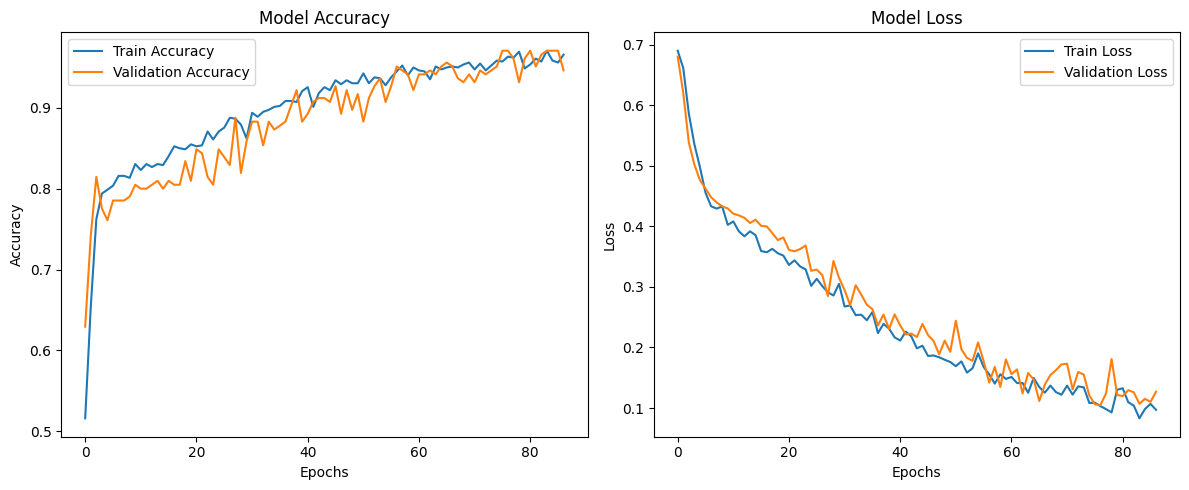

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


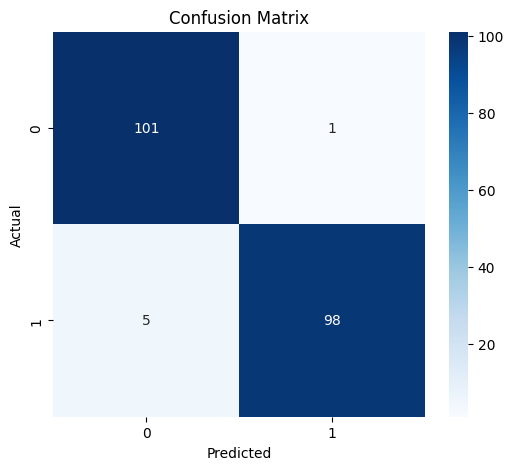

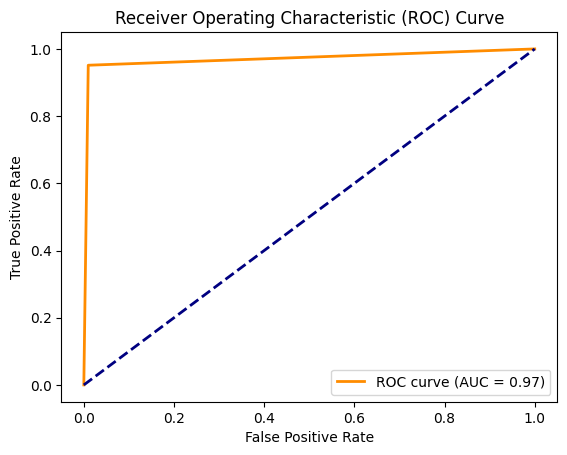

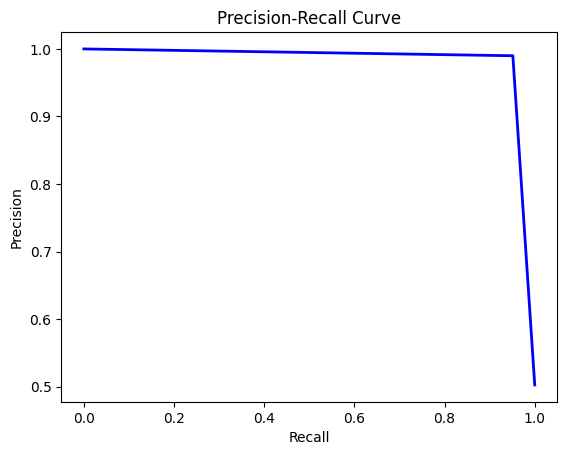

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import joblib

# Load dataset
file_path = '/content/heart.csv'
df = pd.read_csv(file_path)

# Use only the features specified in Gradio
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "thalach", "target"]
df = df[columns]

# Split data into features and labels
X = df.drop("target", axis=1)
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build a more complex LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.3))  # Prevent overfitting
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the trained model
model.save('heart_disease_model_simple.h5')
print("Model saved as heart_disease_model_simple.h5")

# Save the model, scaler, and label encoders together as a .pkl file
model_info = {
    'model': 'heart_disease_model_simple.h5',
    'scaler': scaler
}
joblib.dump(model_info, 'heart_disease_model_simple.pkl')
print("Model information saved as heart_disease_model_simple.pkl")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Generate confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
# Import necessary libraries
import gradio as gr
import pandas as pd
import numpy as np
import joblib
from keras.models import load_model
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import os

# Create the offload folder for the chatbot model
offload_folder = "/tmp/offload"
os.makedirs(offload_folder, exist_ok=True)

# Load the Gym Recommendation model and label encoders
model_gym = joblib.load('/content/multi_output_gym_recommendation_model.pkl')

label_encoders = {}
for column in ['Fitness Type', 'Exercises', 'Equipment']:
    label_encoders[column] = joblib.load(f'/content/{column}_label_encoder.pkl')

# Define the function for gym recommendations
def recommend_exercise(Sex, Age, Height, Weight, Hypertension, Diabetes):
    user_input = {
        'Sex': Sex,
        'Age': Age,
        'Height': Height,
        'Weight': Weight,
        'Hypertension': Hypertension,
        'Diabetes': Diabetes
    }
    height = user_input['Height']
    weight = user_input['Weight']
    bmi = weight / (height ** 2)
    user_input['BMI'] = bmi

    # Add additional features
    user_input['Level'] = 1 if bmi >= 18.5 else 0
    user_input['Fitness Goal'] = 0 if bmi >= 25 else 1

    # Encode the input
    user_input_encoded = user_input.copy()
    user_input_encoded['Sex'] = 1 if user_input['Sex'].lower() == 'male' else 0
    user_input_encoded['Hypertension'] = 1 if user_input['Hypertension'].lower() == 'yes' else 0
    user_input_encoded['Diabetes'] = 1 if user_input['Diabetes'].lower() == 'yes' else 0
    df_input = pd.DataFrame([user_input_encoded], columns=['Sex', 'Age', 'Height', 'Weight', 'Hypertension', 'Diabetes'])

    # Make predictions
    prediction = model_gym.predict(df_input)
    fitness_type = label_encoders['Fitness Type'].inverse_transform([int(prediction[0][0])])[0]
    exercises = label_encoders['Exercises'].inverse_transform([int(prediction[0][1])])[0]
    equipment = label_encoders['Equipment'].inverse_transform([int(prediction[0][2])])[0]

    # Format the output
    output = (
        f"You should aim for a type of {fitness_type}.\n"
        f"Exercises Recommended for you are: {exercises}\n"
        f"Using the Equipments: {equipment}"
    )
    return output

# Load the Heart Disease model and scaler
model_info = joblib.load('/content/heart_disease_model_simple.pkl')
model_hd = load_model('/content/' + model_info['model'])  # Ensure the path is correct
scaler = model_info['scaler']

# Define the function for heart disease prediction
def predict_heart_disease(age, sex, cp, trestbps, chol, fbs, thalach):
    # Encode categorical variables
    sex_encoded = int(sex)
    cp_encoded = int(cp)
    fbs_encoded = int(fbs)

    # Prepare the input data
    user_data = np.array([[age, sex_encoded, cp_encoded, trestbps, chol, fbs_encoded, thalach]])
    user_data_scaled = scaler.transform(user_data)
    user_data_scaled = user_data_scaled.reshape((user_data_scaled.shape[0], 1, user_data_scaled.shape[1]))

    # Make the prediction
    prediction = model_hd.predict(user_data_scaled)
    probability = prediction[0][0] * 100

    # Return the result based on the probability
    if probability > 50:
        return f"You might have heart disease. Probability: {probability:.2f}%"
    else:
        return f"You are less likely to have heart disease. Probability: {100 - probability:.2f}%"

# Load the chatbot model and tokenizer
model_name = "ruslanmv/Medical-Llama3-8B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
)
device_map = "auto"

model_chatbot = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map=device_map,
    offload_folder=offload_folder
)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Define the function for chatbot response
def chatbot_response(user_input, chat_history=[]):
    sys_message = '''You are an AI Medical Assistant trained on a vast dataset of health information. Please be thorough and provide an informative answer. If you don't know the answer to a specific medical inquiry, advise seeking professional help.'''

    # Build the prompt
    prompt = f"{sys_message}\n\n"
    for human, assistant in chat_history:
        prompt += f"User: {human}\nAssistant: {assistant}\n"

    prompt += f"User: {user_input}\nAssistant:"

    # Tokenize and generate response
    inputs = tokenizer(prompt, return_tensors="pt").to(model_chatbot.device)
    outputs = model_chatbot.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    response_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = response_text[len(prompt):].split("User:")[0].strip()

    # Update chat history
    chat_history.append((user_input, answer))
    if len(chat_history) > 5:
        chat_history = chat_history[-5:]
    return chat_history, chat_history

# Build the Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Health and Fitness Assistant")

    # Gym Recommendation Tab
    with gr.Tab("🏋️ Gym Recommendation"):
        gr.Markdown("## Get Personalized Exercise Recommendations")
        with gr.Group():
            with gr.Row():
                sex_input_gym = gr.Radio(choices=['Male', 'Female'], label='Sex')
                age_input_gym = gr.Number(value=25, label='Age')
            with gr.Row():
                height_input_gym = gr.Number(value=1.75, label='Height (in meters)')
                weight_input_gym = gr.Number(value=70, label='Weight (in kg)')
            with gr.Row():
                hypertension_input_gym = gr.Radio(choices=['Yes', 'No'], label='Hypertension')
                diabetes_input_gym = gr.Radio(choices=['Yes', 'No'], label='Diabetes')
        btn_gym = gr.Button("Get Recommendation")
        output_gym = gr.Textbox(label="Recommendation", lines=5)
        btn_gym.click(
            fn=recommend_exercise,
            inputs=[sex_input_gym, age_input_gym, height_input_gym, weight_input_gym,
                    hypertension_input_gym, diabetes_input_gym],
            outputs=output_gym
        )

    # Heart Disease Prediction Tab
    with gr.Tab("❤️ Heart Disease Prediction"):
        gr.Markdown("## Predict Your Risk of Heart Disease")
        with gr.Group():
            with gr.Row():
                age_input_hd = gr.Number(label="Age", value=55)
                sex_input_hd = gr.Radio(choices=[0, 1], label="Sex (0 = Female, 1 = Male)", value=1)
                cp_input_hd = gr.Radio(choices=[0, 1, 2, 3], label="Chest Pain Type (0-3)", value=2)
            with gr.Row():
                trestbps_input_hd = gr.Number(label="Resting Blood Pressure", value=130)
                chol_input_hd = gr.Number(label="Serum Cholesterol (mg/dl)", value=250)
            with gr.Row():
                fbs_input_hd = gr.Radio(choices=[0, 1], label="Fasting Blood Sugar > 120 mg/dl (1 = True, 0 = False)", value=0)
                thalach_input_hd = gr.Number(label="Maximum Heart Rate Achieved", value=150)
        btn_hd = gr.Button("Predict")
        output_hd = gr.Textbox(label="Prediction", lines=2)
        btn_hd.click(
            fn=predict_heart_disease,
            inputs=[age_input_hd, sex_input_hd, cp_input_hd, trestbps_input_hd,
                    chol_input_hd, fbs_input_hd, thalach_input_hd],
            outputs=output_hd
        )

    # Chatbot Tab
    with gr.Tab("💬 Chatbot"):
        gr.Markdown("## Chat with the AI Medical Assistant")
        with gr.Group():
            chatbot = gr.Chatbot(label="AI Assistant", height=400)
            msg = gr.Textbox(label="Your Message", placeholder="Type your message here and press Enter")
            chat_history = gr.State([])
            btn_clear = gr.Button("Clear Conversation")
            def submit_message(user_input, chat_history):
                new_history, _ = chatbot_response(user_input, chat_history)
                return new_history, new_history
            msg.submit(submit_message, [msg, chat_history], [chatbot, chat_history])
            msg.submit(lambda: "", None, msg)
            btn_clear.click(lambda: ([], []), None, [chatbot, chat_history])

# Launch the Gradio interface
demo.launch(debug=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:225: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://68f54d9f3767973942.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Load the saved model
model_filename = 'multi_output_gym_recommendation_model.pkl'
model = joblib.load(model_filename)

# Extract one of the Random Forest estimators for one of the output targets
# For multi-output, RandomForest has multiple estimators, one for each target
target_index = 0  # Change this to visualize a different output (0 for 'Fitness Type', etc.)
tree_index = 0  # Index of the tree within the Random Forest

# Extract the specific estimator
tree = model.named_steps['classifier'].estimators_[target_index].estimators_[tree_index]

# Define feature names for better visualization
feature_names = ['Sex', 'Age', 'Height', 'Weight', 'Hypertension', 'Diabetes']

# Export the tree in DOT format and convert it using pydotplus
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=feature_names,
                           filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)

# Show the graph in a Jupyter notebook (or save it as an image file)
Image(graph.create_png())

# To save as an image file, uncomment the line below
graph.write_png('multi_output_tree_visualization.png')
print("Tree visualization saved as 'multi_output_tree_visualization.png'")


Tree visualization saved as 'multi_output_tree_visualization.png'


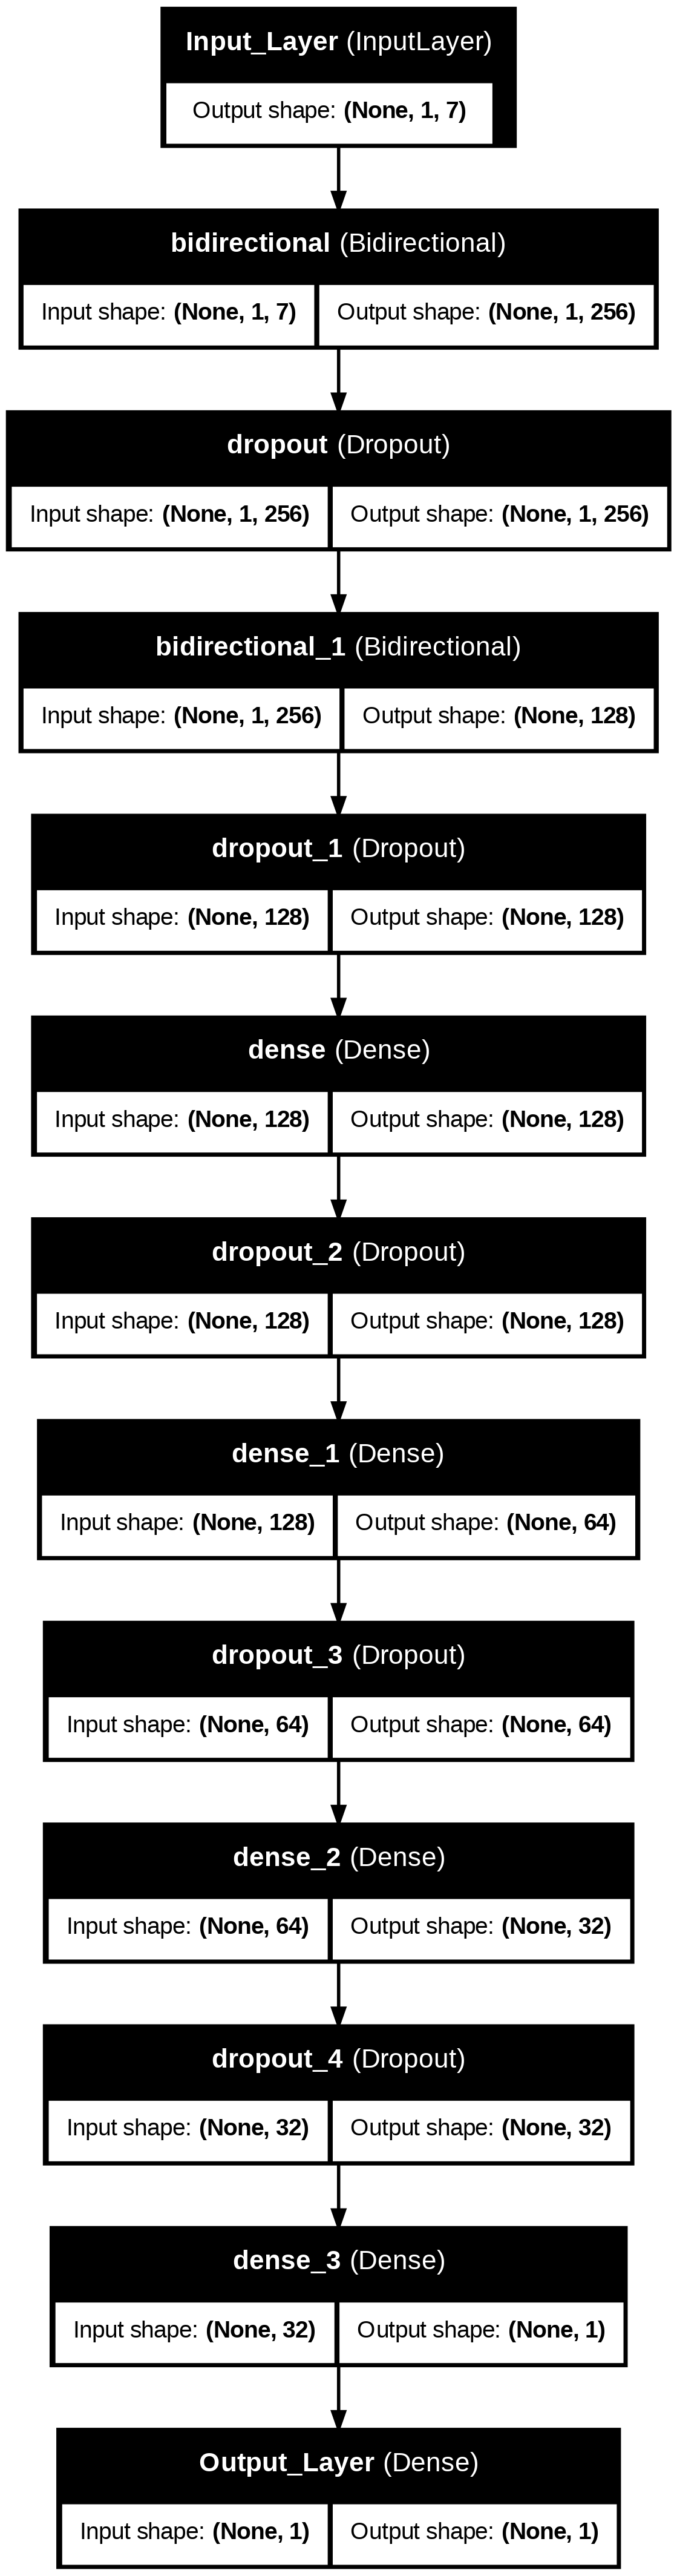

In [7]:
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential
import pydot

# Load the saved LSTM model
model = tf.keras.models.load_model('heart_disease_model_simple.h5')

# Convert the Sequential model into a functional model for better visualization
input_layer = tf.keras.layers.Input(shape=(model.input_shape[1], model.input_shape[2]), name='Input_Layer')
x = input_layer

for layer in model.layers:
    x = layer(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='Output_Layer')(x)
model_with_io = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='LSTM_Model_With_IO')

# Visualize the entire model structure with input and output layers
plot_model(model_with_io, to_file='lstm_model_structure_with_io_full.png', show_shapes=True, show_layer_names=True)

# Display the model structure as an image
from IPython.display import Image
Image(filename='lstm_model_structure_with_io_full.png')
